Plan:


- forecasting a plotting the forecast: https://medium.com/swlh/temperature-forecasting-with-arima-model-in-python-427b2d3bcb53  
`start=len(train)`  
`end=len(train)+len(test)-1`  
`pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')`  
`pred.plot(legend=True)`  
`test['AvgTemp'].plot(legend=True)`  

### DEV:

In [ ]:
# pip install chowtest

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm # may have this one already somewhere in the notebook
from statsmodels.tsa.arima.model import ARIMA
from chow_test import chowtest

# from sklearn.metrics import mean_squared_error
import math

pd.options.display.max_rows = 999 # to display all rows
pd.options.display.max_columns = 999 # to display all columns

In [2]:
miles_df = pd.read_csv("Data/Mileage.csv", engine = "python")
miles_df.set_index('Monday',inplace=True)
miles_df.index = pd.to_datetime(miles_df.index)

In [3]:
miles_df

,Mileage,Notes
Monday,,
2019-08-19,293.8,NaN
2019-08-26,955.0,Milwaukee
2019-09-02,167.8,NaN
2019-09-09,411.4,La Crosse
2019-09-16,958.9,Chicago
2019-09-23,87.0,NaN
2019-09-30,130.1,NaN
2019-10-07,1007.5,Chicago
2019-10-14,88.3,NaN


In [4]:
miles_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2019-08-19 to 2020-12-14
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mileage  69 non-null     float64
 1   Notes    12 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


### Idenity week(s) where mileage was not recorded

In [5]:
miles_df[miles_df["Mileage"].isnull()]

,Mileage,Notes
Monday,,
2020-03-09,NaN,Car battery died


### How should the missing value be imputed?

In [6]:
miles_df.describe()

,Mileage
count,69.000000
mean,169.723188
std,244.174248
min,0.000000
25%,44.700000
50%,87.000000
75%,150.400000
max,1007.500000


mean? median? or perhaps something more specific?

In [7]:
miles_df.loc[:,"Notes"].unique()

array([nan, 'Milwaukee', 'La Crosse', 'Chicago', 'Car battery died',
       'Milwaukee; Coronavirus begins, 3/11 NBA postponed season',
       'Redwood Falls and Mankato', 'Winona', 'Mankato'], dtype=object)

In [8]:
# identify when travel occurred; notes only exist for travels outside metro area
miles_df["travel_ind"] = np.where(miles_df['Notes'].notnull(), 1, 0)

# car battery died and no travel occurred
miles_df["travel_ind"] = np.where(miles_df['Notes'].str.lower().str.contains("car battery", na = False), 
                                   0, miles_df["travel_ind"])

I travel to Chicago a lot.

In [9]:
miles_df.groupby(["Notes"]).agg({"travel_ind":"count"}).sort_values("travel_ind", ascending = False)

,travel_ind
Notes,
Chicago,5
Car battery died,1
La Crosse,1
Mankato,1
Milwaukee,1
"Milwaukee; Coronavirus begins, 3/11 NBA postponed season",1
Redwood Falls and Mankato,1
Winona,1


Group by `travel_ind` and get average mileage.

In [10]:
grouped_df = miles_df.groupby(["travel_ind"]).agg({"Mileage":["count","mean","median"]})
grouped_df

Mileage                   
             count        mean median
travel_ind                           
0               58   87.389655   73.8
1               11  603.845455  411.4

Imputing values is more of an art than a science. Because this is a time series, we want to try to retain as many observations as possible. Because the median of the series is 87 miles, and the mean of the category of weeks where I didn't travel is about 87 miles, we can feel comfortable imputing a value of approximately 87 for the missing value. 

It won't always be this conclusive when imputing values and reducing bias in the observations, but because the overall median is similar to the mean during non-traveling weeks, the solution is appropriate.  

Let's impute missing values for mileage with mean of weeks where I didn't travel.

In [11]:
# exclude first level of multi-indexed columns resulting from the groupby
grouped_df.columns = grouped_df.columns.droplevel(0)

# get the number to impute the null value in Mileage
non_travel_mean_mileage = grouped_df.loc[0, "mean"].round(1)
non_travel_mean_mileage

87.4

### Impute missing mileage value

In [12]:
miles_df

,Mileage,Notes,travel_ind
Monday,,,
2019-08-19,293.8,NaN,0
2019-08-26,955.0,Milwaukee,1
2019-09-02,167.8,NaN,0
2019-09-09,411.4,La Crosse,1
2019-09-16,958.9,Chicago,1
2019-09-23,87.0,NaN,0
2019-09-30,130.1,NaN,0
2019-10-07,1007.5,Chicago,1
2019-10-14,88.3,NaN,0


In [13]:
miles_df["Mileage"] = np.where(miles_df["Mileage"].isnull(), non_travel_mean_mileage, miles_df["Mileage"]).round(1)

miles_df.loc[pd.to_datetime(['3/2/2020', '3/9/2020', '3/16/2020'])]

,Mileage,Notes,travel_ind
2020-03-02,124.6,NaN,0
2020-03-09,87.4,Car battery died,0
2020-03-16,843.3,"Milwaukee; Coronavirus begins, 3/11 NBA postpo...",1


Mileage field is ready to be used.

### Histogram

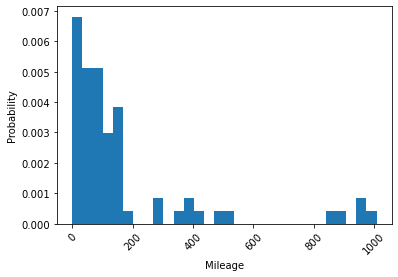

In [14]:
plt.hist(miles_df["Mileage"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Mileage")
plt.xticks(rotation = 45)
plt.show()

### Trend over Time

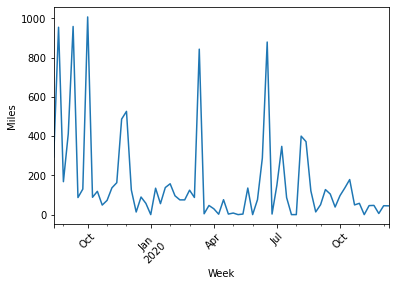

In [15]:
miles_df["Mileage"].plot()
plt.ylabel("Miles")
plt.xlabel("Week")
plt.xticks(rotation = 45)
plt.show()

If trend exists, then the series is not staitonary, and will require differencing, at least a difference order of 1.  

Appears to be stationary.

Take the log because the histogram shows a right-skew in the data. 

Add 1 to the level of the Mileage series because you can't take the log(0) ( log(0) = inf). As a result, we scale the level of Mileage by +1.

In [16]:
# can't take log of 0, so offset Mileage by 2 miles
miles_df["Mileage_log"] = np.log(miles_df["Mileage"]+2)
miles_df["Mileage"] = miles_df["Mileage"]+1

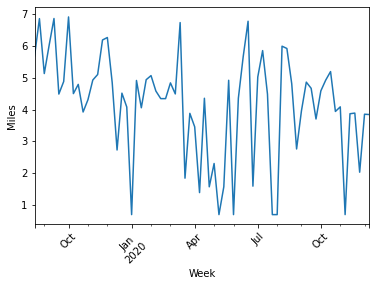

In [17]:
miles_df["Mileage_log"].plot()
plt.ylabel("Miles")
plt.xlabel("Week")
plt.xticks(rotation = 45)
plt.show()

### Decomposition of Time Series

There seems to be a downward trend in mileage in the Spring. There is only one Spring season in this dataset. This also coincides with the start of the Coronavirus pandemic (March 2020, as defined for this analysis). We will delve into this downward trend. From a decomposition point of view, the Mileage time series doesn't seem to suffer much from trends or seasonality effects. 

In [18]:
# seasonal_df = miles_df[["Mileage"]]
# seasonal_df.index = pd.to_datetime(seasonal_df.index)
# seasonal_decompose(seasonal_df, extrapolate_trend = "freq").plot()
# plt.show()

In [19]:
# seasonal_df = miles_df[["Mileage_log"]]
# seasonal_df.index = pd.to_datetime(seasonal_df.index)
# seasonal_decompose(seasonal_df, extrapolate_trend = "freq").plot()
# plt.show()

### Testing Stationarity

the series' mean should not be a function of time; its mean should not drift over time.
    
the series' variance should not be a function of time; its variance should not expand/contract over time (homoskedasticity = variance is not a function of time).  

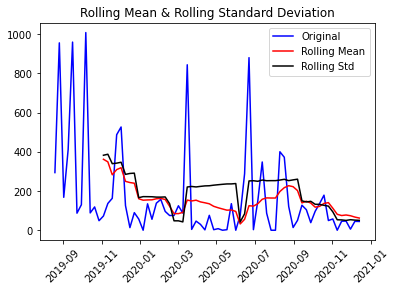

In [20]:
# check rolling mean (eye test)  
rolling_mean = miles_df[["Mileage"]].rolling(window = 12).mean()
rolling_std = miles_df[["Mileage"]].rolling(window = 12).std()
plt.plot(miles_df[["Mileage"]], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.xticks(rotation = 45)
plt.show()

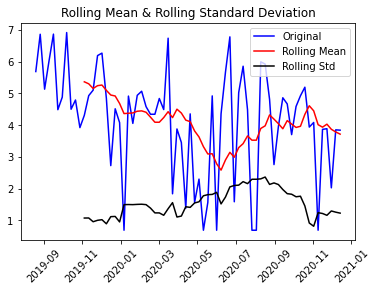

In [21]:
# check rolling mean (eye test)  
rolling_mean = miles_df[["Mileage_log"]].rolling(window = 12).mean()
rolling_std = miles_df[["Mileage_log"]].rolling(window = 12).std()
plt.plot(miles_df[["Mileage_log"]], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.xticks(rotation = 45)
plt.show()

ADF
- helps decide to difference or not  
- null hypothesis = unit root (non-stationary)
- alternative = stationary
- Ho: It is non-stationary  
- H1: It is stationary  
- The null hypothesis for both tests is that the data are non-stationary. We want to REJECT the null hypothesis for this test, so we want a p-value of less that 0.05 (or smaller).


In [22]:
# ADF Test
adf_result = adfuller(miles_df['Mileage'], autolag = 'AIC')  
print("1. ADF : ", "\t\t\t\t\t\t", adf_result[0])  
print("2. P-Value : ", "\t\t\t\t\t\t", adf_result[1])
print("3. Num Of Lags : ", "\t\t\t\t\t", adf_result[2])
print("4. Num Of Observations Used For ADF Regression:", "\t", adf_result[3])
print("5. Critical Values :")
for key, val in adf_result[4].items():
    print("\t",key, ": ", val)

1. ADF :  						 -7.186084789343308
2. P-Value :  						 2.574722741926325e-10
3. Num Of Lags :  					 0
4. Num Of Observations Used For ADF Regression: 	 69
5. Critical Values :
	 1% :  -3.528889992207215
	 5% :  -2.9044395987933362
	 10% :  -2.589655654274312


In [23]:
# ADF Test Log
adf_result_log = adfuller(miles_df['Mileage_log'], autolag = 'AIC')  
print("1. ADF : ", "\t\t\t\t\t\t", adf_result_log[0])  
print("2. P-Value : ", "\t\t\t\t\t\t", adf_result_log[1])
print("3. Num Of Lags : ", "\t\t\t\t\t", adf_result_log[2])
print("4. Num Of Observations Used For ADF Regression:", "\t", adf_result_log[3])
print("5. Critical Values :")
for key, val in adf_result_log[4].items():
    print("\t",key, ": ", val)

1. ADF :  						 -6.511176539653745
2. P-Value :  						 1.0994442151373825e-08
3. Num Of Lags :  					 0
4. Num Of Observations Used For ADF Regression: 	 69
5. Critical Values :
	 1% :  -3.528889992207215
	 5% :  -2.9044395987933362
	 10% :  -2.589655654274312


For KPSS, null hypothesis is that the data are stationary. Want to fail to reject the null hypothesis to show data are stationary.

In [24]:
# KPSS Test  
kpss_result = kpss(miles_df["Mileage"].values, regression='c', lags = "legacy")
print('\nKPSS Statistic: \t %f' % result[0])
print('p-value: \t\t %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

<ipython-input-24-b50ac10d747b>:2: FutureWarning: the 'lags'' keyword is deprecated, use 'nlags' instead
  kpss_result = kpss(miles_df["Mileage"].values, regression='c', lags = "legacy")


NameError: name 'result' is not defined

In [26]:
# KPSS Test Log
kpss_result_log = kpss(miles_df["Mileage_log"].values, regression='c', lags = "legacy")
print('\nKPSS Statistic: \t %f' % kpss_result_log[0])
print('p-value: \t\t %f' % kpss_result_log[1])
for key, value in kpss_result_log[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 	 0.391289
p-value: 		 0.080910
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


<ipython-input-26-8f3887320907>:2: FutureWarning: the 'lags'' keyword is deprecated, use 'nlags' instead
  kpss_result_log = kpss(miles_df["Mileage_log"].values, regression='c', lags = "legacy")


### Analyzing Autocorrelation and Moving Average

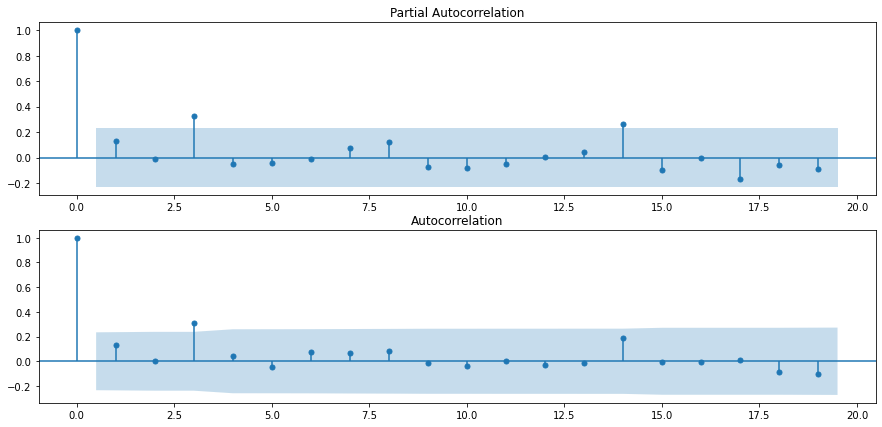

In [27]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
fig = plot_pacf(miles_df['Mileage'], ax=ax1) # AR
ax2 = fig.add_subplot(212)
fig = plot_acf(miles_df['Mileage'], ax=ax2) #MA

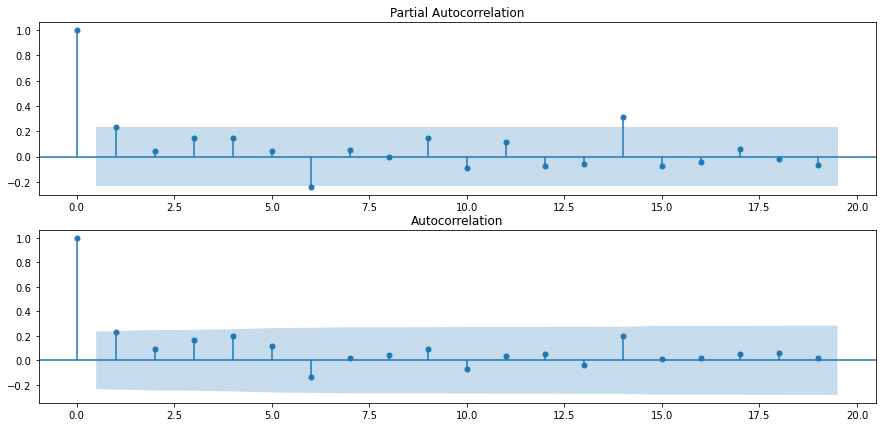

In [28]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
fig = plot_pacf(miles_df['Mileage_log'], ax=ax1) # AR
ax2 = fig.add_subplot(212)
fig = plot_acf(miles_df['Mileage_log'], ax=ax2) # MA

### Split into Train and Test Datasets

In [29]:
miles_df

,Mileage,Notes,travel_ind,Mileage_log
Monday,,,,
2019-08-19,294.8,NaN,0,5.689684
2019-08-26,956.0,Milwaukee,1,6.863803
2019-09-02,168.8,NaN,0,5.134621
2019-09-09,412.4,La Crosse,1,6.024416
2019-09-16,959.9,Chicago,1,6.867870
2019-09-23,88.0,NaN,0,4.488636
2019-09-30,131.1,NaN,0,4.883559
2019-10-07,1008.5,Chicago,1,6.917210
2019-10-14,89.3,NaN,0,4.503137


In [30]:
# test period will be last 10 observations  
train_df = miles_df.iloc[:-10]  
test_df = miles_df.iloc[-10:]

print("Original dataset shape", miles_df.shape)
print("Train shape:", train_df.shape) 
print("Test shape:", test_df.shape)

Original dataset shape (70, 4)
Train shape: (60, 4)
Test shape: (10, 4)


In [ ]:
train_df

In [ ]:
test_df

### ARIMA

/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                Mileage   No. Observations:                   60
Model:                          ARIMA   Log Likelihood                -417.590
Date:                Thu, 28 Jan 2021   AIC                            839.180
Time:                        13:26:52   BIC                            843.369
Sample:                    08-19-2019   HQIC                           840.818
                         - 10-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.4717     74.114      2.529      0.011      42.210     332.733
sigma2      6.501e+04   1.63e+04      3.999      0.000    3.31e+04    9.69e+04
Ljung-Box (L1) (Q):                   0.60   Jarque-

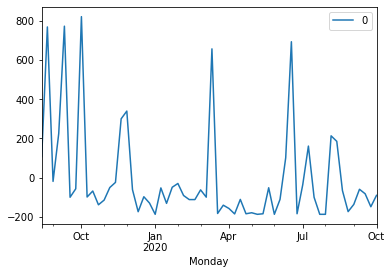

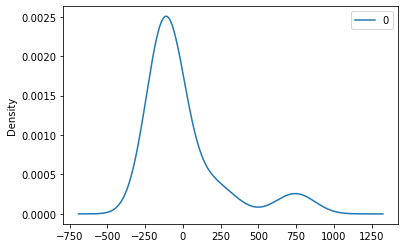

                0
count   60.000000
mean     0.000005
std    257.056886
min   -186.471661
25%   -141.946661
50%    -93.721661
75%    -27.896661
max    821.028339


In [31]:
# fit model  
model = ARIMA(train_df["Mileage"], order=(0,0,0))
model_fit = model.fit()
# # summary of fit model  
print(model_fit.summary())
# # line plot of residuals  
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()  
plt.show()
# # density plot of residuals  
residuals.plot(kind='kde')  
plt.show()  

# summary stats of residuals  
print(residuals.describe())  

# prediction  
#     - "We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d>0 when configuring the model). This can be specified by setting the typ argument to the value ‘levels’: typ=’levels’."
#     - can also use forecast()  
#         `output = model_fit.forecast()`  
#         `yhat = output[0]`

In [ ]:
# # fit model  
# model = ARIMA(train_df["Mileage_log"], order=(0,0,0))  
# model_fit = model.fit()  
# plt.plot(train_df["Mileage_log"])
# plt.plot(model_fit.fittedvalues, color='red') 

# # in-sample prediction  
# predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# predictions_ARIMA_log = pd.Series(train_df["Mileage"].iloc[0], index=train_df.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
# predictions_ARIMA = np.exp(predictions_ARIMA_log)
# plt.plot(predictions_ARIMA)  
# # #  out-of-sample prediction  
# model_fit.plot_predict(1,264)

/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                Mileage   No. Observations:                   60
Model:                          ARIMA   Log Likelihood                -417.590
Date:                Thu, 28 Jan 2021   AIC                            839.180
Time:                        13:26:53   BIC                            843.369
Sample:                    08-19-2019   HQIC                           840.818
                         - 10-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        187.4717     74.114      2.529      0.011      42.210     332.733
sigma2      6.501e+04   1.63e+04      3.999      0.000    3.31e+04    9.69e+04
Ljung-Box (L1) (Q):                   0.60   Jarque-

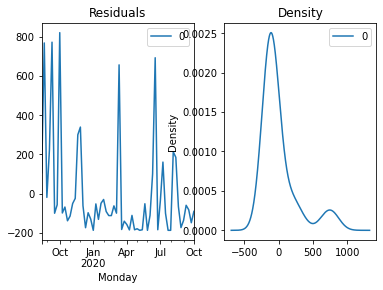

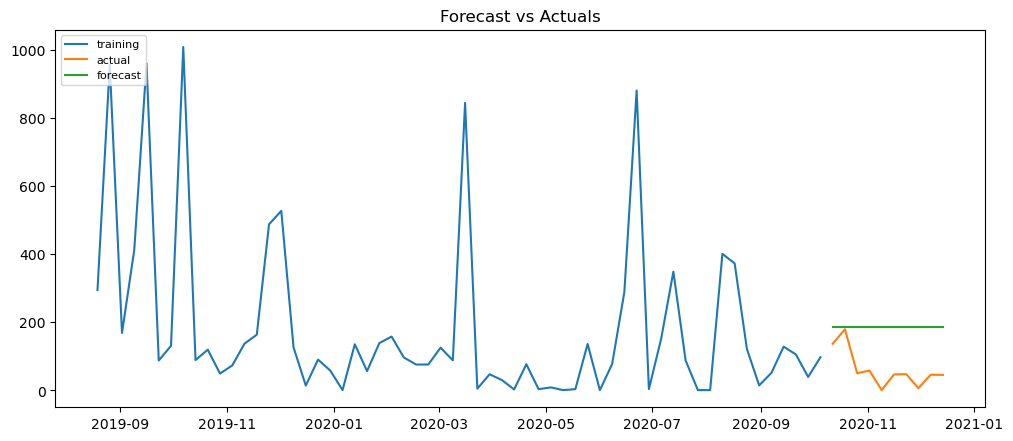

In [32]:
# 1,1,2 ARIMA Model  
model = ARIMA(train_df["Mileage"], order=(0,0,0))  
model_fit = model.fit()
print(model_fit.summary())

# Plot residual errors  
residuals = pd.DataFrame(model_fit.resid) 
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0]) 
residuals.plot(kind='kde', title='Density', ax=ax[1])  
plt.show() 

# Forecast  
# fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf`  
fc = model_fit.forecast(10, alpha=0.05)  # 95% conf`  

# Make as pandas series  
fc_series = pd.Series(fc, index=test_df.index)


# Plot  
plt.figure(figsize=(12,5), dpi=100)  
plt.plot(train_df["Mileage"], label='training')
plt.plot(test_df["Mileage"], label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:            Mileage_log   No. Observations:                   60
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -115.191
Date:                Thu, 28 Jan 2021   AIC                            236.382
Time:                        13:26:57   BIC                            242.665
Sample:                    08-19-2019   HQIC                           238.840
                         - 10-05-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2623      0.331     12.862      0.000       3.613       4.912
ar.L1          0.2326      0.117      1.983      0.047       0.003       0.463
sigma2         2.7207      0.630      4.322      0.0

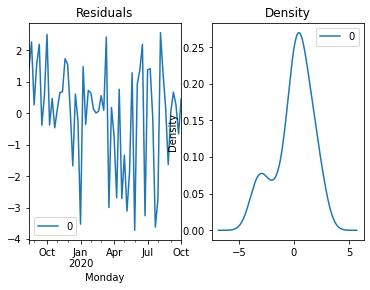

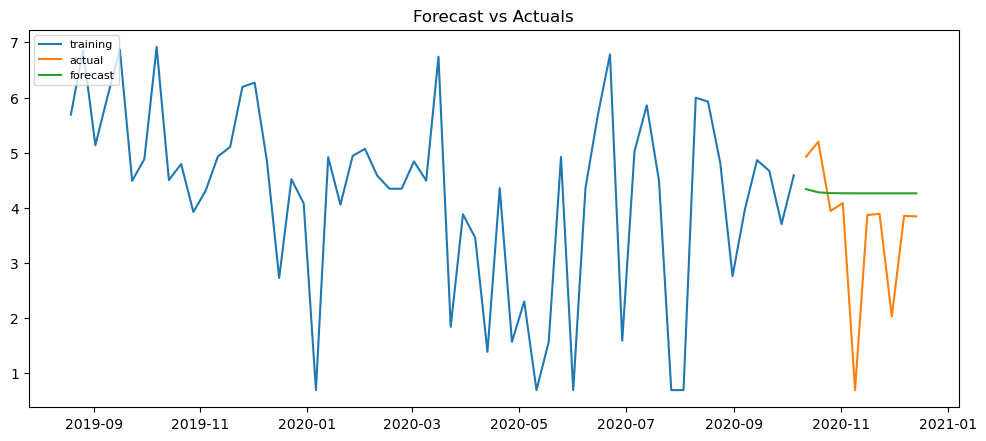

In [33]:
# 1,1,2 ARIMA Model  
model = ARIMA(train_df["Mileage_log"], order=(1,0,0))  
model_fit = model.fit()
print(model_fit.summary())

# Plot residual errors  
residuals = pd.DataFrame(model_fit.resid) 
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0]) 
residuals.plot(kind='kde', title='Density', ax=ax[1])  
plt.show() 

# Forecast  
# fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf`  
fc_log = model_fit.forecast(10, alpha=0.05)  # 95% conf`  

# Make as pandas series  
# fc_series = pd.Series(fc, index=test_df.index)
fc_series = pd.Series(fc_log)


# Plot  
plt.figure(figsize=(12,5), dpi=100)  
plt.plot(train_df["Mileage_log"], label='training')
plt.plot(test_df["Mileage_log"], label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Forecasting Metrics

In [34]:
def performance_metrics(predicted, actual):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))*100  # MAPE 
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)*100   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    corr = np.corrcoef(predicted, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([predicted[:,None], actual[:,None]]), axis=1) 
#     maxs = np.amax(np.hstack([predicted[:,None], actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 
            'me':me,
            'mae': mae,
            'mpe': mpe, 
            'rmse':rmse, 
            'corr':corr})  

# forecast_accuracy(fc, test.values) 

In [35]:
performance_metrics(fc, test_df["Mileage"])

/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Maddie/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


{'mape': 2312.761961877445,
 'me': 125.471661216272,
 'mae': 125.471661216272,
 'mpe': 2312.761961877445,
 'rmse': 135.93619006125974,
 'corr': nan}

In [36]:
performance_metrics(fc_log, test_df["Mileage_log"])

{'mape': 70.85023039827439,
 'me': 0.6392664993487767,
 'mae': 0.9403614208573897,
 'mpe': 64.9324631411319,
 'rmse': 1.4032596586564834,
 'corr': 0.4457414498875893}

### Create Destination Indicators

In [37]:
# miles_df["Milwaukee"] = np.where(miles_df['Notes'].str.lower().str.contains("milwaukee", na = False), 1, 0)
# miles_df["Chicago"] = np.where(miles_df['Notes'].str.lower().str.contains("chicago", na = False), 1, 0)

### Identifying when Coronovirus started

In [38]:
miles_df.loc[miles_df['Notes'].str.lower().str.contains("coronavirus", na = False)]

,Mileage,Notes,travel_ind,Mileage_log,Milwaukee,Chicago
Monday,,,,,,
2020-03-16,844.3,"Milwaukee; Coronavirus begins, 3/11 NBA postpo...",1,6.739692,1,0


### Chow Breakpoint Test

test whether one regression or two or more regressions best characterise the data. 

test is capable of detecting "structural breaks" within time-series

In [39]:
chowtest(y = miles_df[["Mileage"]],
         X = miles_df[["travel_ind"]],
         last_index_in_model_1 = "2020-03-09",
         first_index_in_model_2 = "2020-03-16",
         significance_level = 0.05)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 12.752858942889294 p value: 0.0
****************************************************************************************************


(12.752858942889294, 1.1116191744875437e-08)

In [40]:
chowtest(y = miles_df[["Mileage"]],
         X = miles_df[["travel_ind","Milwaukee","Chicago"]],
         last_index_in_model_1 = "2020-03-09",
         first_index_in_model_2 = "2020-03-16",
         significance_level = 0.05)

****************************************************************************************************
Reject the null hypothesis of equality of regression coefficients in the 2 periods.
****************************************************************************************************
Chow Statistic: 8.786592900213678 p value: 0.0
****************************************************************************************************


(8.786592900213678, 2.411714624450667e-06)

### Create Covid Indicator in Training Dataset

In [62]:
# create indicator for Coronavirus period vs non-Coronavirus period
train_df["covid_ind"] = np.where(train_df.index >= "2020-03-16", 1, 0)

train_df.groupby(["covid_ind"]).agg({"Mileage":["count","mean","median"]})

<ipython-input-62-3aab587f36ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["covid_ind"] = np.where(train_df.index >= "2020-03-16", 1, 0)


Mileage                    
            count        mean  median
covid_ind                            
0              30  230.366667  126.05
1              30  144.576667   64.25

In [64]:
train_df.head()

,Mileage,Notes,travel_ind,Mileage_log,covid_ind
Monday,,,,,
2019-08-19,294.8,NaN,0,5.689684,0
2019-08-26,956.0,Milwaukee,1,6.863803,0
2019-09-02,168.8,NaN,0,5.134621,0
2019-09-09,412.4,La Crosse,1,6.024416,0
2019-09-16,959.9,Chicago,1,6.867870,0


In [65]:
train_df.tail()

,Mileage,Notes,travel_ind,Mileage_log,covid_ind
Monday,,,,,
2020-09-07,51.5,NaN,0,3.960813,1
2020-09-14,128.6,NaN,0,4.864453,1
2020-09-21,105.7,NaN,0,4.670021,1
2020-09-28,39.6,NaN,0,3.703768,1
2020-10-05,97.5,NaN,0,4.590057,1


### OLS with exogenous features and no lag

In [ ]:
import statsmodels.api as sm

In [ ]:
miles_x = miles_df[["travel_ind","covid_ind","Milwaukee","Chicago"]]
miles_y = miles_df[["Mileage"]]

In [ ]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

In [ ]:
miles_x = miles_df[["travel_ind","covid_ind"]]
miles_y = miles_df[["Mileage"]]

In [ ]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

log Mileage

In [ ]:
miles_x = miles_df[["travel_ind","covid_ind","Milwaukee","Chicago"]]
miles_y = miles_df[["Mileage_log"]]

In [ ]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

In [ ]:
miles_x = miles_df[["travel_ind","covid_ind"]]
miles_y = miles_df[["Mileage_log"]]

In [ ]:
# statsmodels function doesn't include a constant term, so, add a constant term to the equation.
X = sm.add_constant(miles_x)
model = sm.OLS(miles_y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

Notes:
    
Mileage is not normally distributed, as expected. I don't regularly travel long distance. Further, driving less during the covid pandemic skews the istribution further. A non-normal distribution makes it harder to capture the pattern in weekly mileage. This is the nature of the data and what we want to explore in the first place, not statistically correct it.

DB-stat

null hypothesis that the errors are serially uncorrelated against the alternative that they follow a first order autoregressive process

In [ ]:
plt.hist(miles_df["Mileage"], density = False, bins = 20)
plt.ylabel("Count")
plt.xlabel("Miles")
plt.xticks(rotation = 45)
plt.show()

In [ ]:
plt.hist(miles_df["Mileage"], density = True, bins = 30)
plt.ylabel("Probability")
plt.xlabel("Miles")
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

In [ ]:
miles_df["Mileage"].plot()
plt.show()

### OLS with exogenous features with lag1